# Checkpoint 12: Determing the momentum resolution for muon tracks at LHCb with NN Regression

In [43]:
# preamble
import numpy as np
import urllib.request
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib_inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import EarlyStopping


# fetch the csv
path = Path("mc-chic1.csv")
if not path.is_file():
    urllib.request.urlretrieve("https://cernbox.cern.ch/index.php/s/oEJHJq0fFv3KcGP/download", "mc-chic1.csv")

In [2]:
df = pd.read_csv("mc-chic1.csv", sep=',')
df = df.drop('Unnamed: 0', 1)
df.dropna(inplace=True)
df.head()

C:\Users\Gamer2021\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,ep,eta,p,phi,pol,pt,qp,tx,ty,zV
0,0.005459,3.210803,72.079880,0.294754,1.0,5.803692,72.079880,0.077296,0.023467,-60.3975
1,0.004050,4.436362,37.638340,-0.088796,1.0,0.891071,-37.638340,0.023588,-0.002100,-60.3975
2,0.003901,3.577396,18.565832,0.319936,1.0,1.036960,18.565832,0.053102,0.017594,-60.3975
3,0.003859,3.532860,8.632520,0.219504,1.0,0.504075,-8.632520,0.057089,0.012736,-60.3975
4,0.004975,3.300828,43.359665,-0.720869,1.0,3.191501,43.359665,0.055445,-0.048714,-8.0373


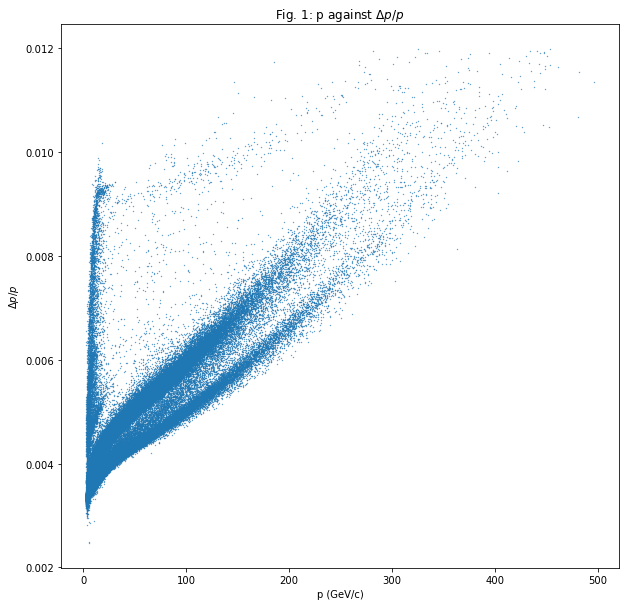

In [3]:
# reproducing figure 1

# getting the same domain as the figure, to highlight the bands
x = df.p[df.p <= 400]
y = df.ep[df.p <= 400]
# getting the same range as the figure
y = df.ep[df.ep <= 0.012]
x = df.p[df.ep <= 0.012]
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, 0.1)
ax.set_xlabel("p (GeV/c)")
ax.set_ylabel(r"$\Delta p/p$")
ax.set_title("Fig. 1: p against $\Delta p/p$")
plt.show()

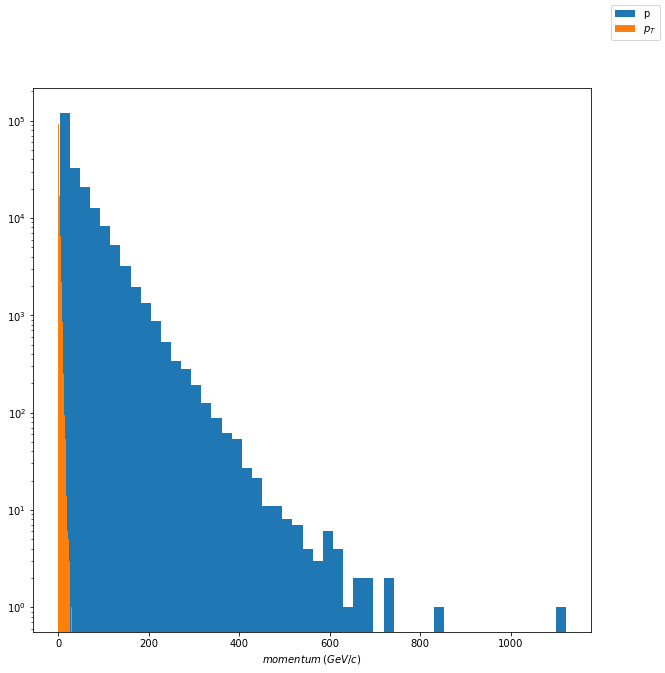

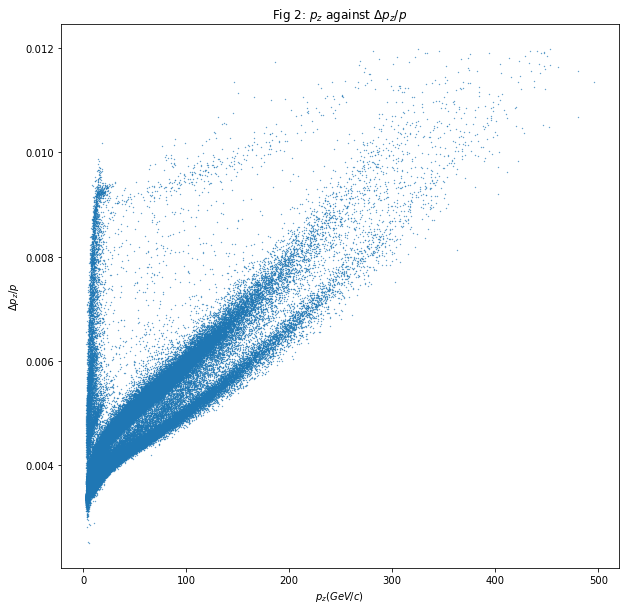

In [4]:
#plot p and p_t distributions in log scale
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(df.p, bins=50, label='p')
ax.hist(df.pt, bins=50, label='$p_T$')
ax.set_yscale('log')
fig.legend()
ax.set_xlabel("$momentum\; (GeV/c)$")
plt.show()
df['pz'] = np.sqrt(df.p ** 2 - df.pt ** 2)
df['epz'] = df.ep * df.p / df.pz

# repeat figure 1 but for epz and pz
# getting the same domain as the figure, to highlight the bands
x = df.pz[df.p <= 400]
y = df.epz[df.p <= 400]
# getting the same range as the figure
y = df.epz[df.ep <= 0.012]
x = df.pz[df.ep <= 0.012]
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, 0.1)
ax.set_xlabel("$p_z (GeV/c)$")
ax.set_ylabel(r"$\Delta p_z/p$")
ax.set_title("Fig 2: $p_z$ against $\Delta p_z/p$")
plt.show()

Note that the $p_T$ distribution is far more tightly clustered around 0 than the p distribution, suggesting $p_T \ll p_z$

Fig 2 is qualitatively identical to fig 1 with the same bands over the same range

In [55]:
# prepare the dataset
data = df[['p', 'tx', 'ty', 'eta', 'phi']].copy().values
target = df['ep'].copy().values

In [56]:
# num of inputs = 5 (p, tx , ty , eta , phi ), num of outputs = 1 (ep)
num_inputs = 5
num_outputs = 1
# simple Keras model : use same # of nodes as # of inputs , single layer
num_nodes = num_inputs
def simple_model():
    # create model
    model = Sequential()
    # no activation required for the output , as this is a regression problem ,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_nodes, input_dim = num_inputs, kernel_initializer='normal', activation ='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [14]:
N_epochs = 100
batchSize = 1000
# must always set the random seed for reproducibility
seed = 42
np.random.seed(seed)

In [15]:
estimator = KerasRegressor(build_fn=simple_model, epochs=N_epochs, batch_size = batchSize, verbose=1)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
# data and target are 5- column and 1- column arrays produced with pandas.DataFrame.values
simple_results = cross_val_score(estimator, data, target, cv=kfold, scoring='r2')
print("Standardised: %.2f %s %.2f" % (simple_results.mean(), u"\u00B1", simple_results.std()))

Epoch 1/100
189/189 [==============================] - 1s 2ms/step - loss: 1.5029e-06
Epoch 2/100
189/189 [==============================] - 0s 2ms/step - loss: 1.0247e-06
Epoch 3/100
189/189 [==============================] - 0s 2ms/step - loss: 1.0122e-06
Epoch 4/100
189/189 [==============================] - 0s 2ms/step - loss: 9.3572e-07
Epoch 5/100
189/189 [==============================] - 0s 2ms/step - loss: 8.2061e-07
Epoch 6/100
189/189 [==============================] - 0s 2ms/step - loss: 8.1480e-07
Epoch 7/100
189/189 [==============================] - 0s 2ms/step - loss: 8.0337e-07
Epoch 8/100
189/189 [==============================] - 0s 2ms/step - loss: 7.8773e-07
Epoch 9/100
189/189 [==============================] - 0s 2ms/step - loss: 7.8026e-07
Epoch 10/100
189/189 [==============================] - 0s 2ms/step - loss: 7.8657e-07
Epoch 11/100
189/189 [==============================] - 0s 2ms/step - loss: 7.8415e-07
Epoch 12/100
189/189 [==============================

In [16]:
# using the pipelined method for standardised inputs
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=simple_model,\
epochs=N_epochs, batch_size=batchSize)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
# data and target are 5- column and 1- column arrays produced with pandas.DataFrame.values
std_results = cross_val_score(pipeline, data, target, cv=kfold, scoring='r2')
print("Standardised: %.2f %s %.2f" % (std_results.mean(), u"\u00B1", std_results.std()))


Epoch 1/100
189/189 [==============================] - 1s 2ms/step - loss: 6.7604e-06
Epoch 2/100
189/189 [==============================] - 0s 2ms/step - loss: 6.2168e-07
Epoch 3/100
189/189 [==============================] - 0s 2ms/step - loss: 5.3090e-07
Epoch 4/100
189/189 [==============================] - 0s 2ms/step - loss: 4.9446e-07
Epoch 5/100
189/189 [==============================] - 0s 2ms/step - loss: 4.5099e-07
Epoch 6/100
189/189 [==============================] - 0s 2ms/step - loss: 4.3130e-07
Epoch 7/100
189/189 [==============================] - 0s 2ms/step - loss: 4.1735e-07
Epoch 8/100
189/189 [==============================] - 0s 2ms/step - loss: 4.0101e-07
Epoch 9/100
189/189 [==============================] - 0s 2ms/step - loss: 3.9643e-07
Epoch 10/100
189/189 [==============================] - 0s 2ms/step - loss: 3.8902e-07
Epoch 11/100
189/189 [==============================] - 0s 2ms/step - loss: 3.8762e-07
Epoch 12/100
189/189 [==============================

For the pipeline method, the mean is .1 higher but the standard deviation is an order of magnitude smaller

In [17]:
# creating a denser_model based on a simple_model
def denser_model():
    # create model
    model = Sequential()
    # no activation required for the output , as this is a regression problem ,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_nodes, input_dim = num_inputs, kernel_initializer='normal', activation ='relu'))
    model.add(Dense(num_inputs, input_dim = num_nodes, kernel_initializer='normal', activation='relu' ))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [18]:
# repeat the pipelined estimator using the denser model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=denser_model,\
epochs=N_epochs, batch_size=batchSize)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
# data and target are 5- column and 1- column arrays produced with pandas.DataFrame.values
dense_results = cross_val_score(pipeline, data, target, cv=kfold, scoring='r2')
print("Standardised: %.2f %s %.2f" % (dense_results.mean(), u"\u00B1", dense_results.std()))

Epoch 1/100
189/189 [==============================] - 1s 2ms/step - loss: 1.4432e-06
Epoch 2/100
189/189 [==============================] - 0s 2ms/step - loss: 5.5207e-07
Epoch 3/100
189/189 [==============================] - 0s 2ms/step - loss: 5.2472e-07
Epoch 4/100
189/189 [==============================] - 0s 2ms/step - loss: 5.2263e-07
Epoch 5/100
189/189 [==============================] - 0s 2ms/step - loss: 5.2033e-07
Epoch 6/100
189/189 [==============================] - 0s 2ms/step - loss: 4.4594e-07
Epoch 7/100
189/189 [==============================] - 0s 2ms/step - loss: 4.0478e-07
Epoch 8/100
189/189 [==============================] - 0s 2ms/step - loss: 3.9774e-07
Epoch 9/100
189/189 [==============================] - 0s 2ms/step - loss: 3.9352e-07
Epoch 10/100
189/189 [==============================] - 0s 2ms/step - loss: 3.9228e-07
Epoch 11/100
189/189 [==============================] - 0s 2ms/step - loss: 3.9103e-07
Epoch 12/100
189/189 [==============================

In [19]:
# return to single layer but use twice as many nodes for a wider approach
def wider_model():
    # create model
    model = Sequential()
    # no activation required for the output , as this is a regression problem ,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_nodes * 2, input_dim = num_inputs, kernel_initializer='normal', activation ='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [20]:
# repeat with the wider model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model,\
epochs=N_epochs, batch_size=batchSize)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
# data and target are 5- column and 1- column arrays produced with pandas.DataFrame.values
wide_results = cross_val_score(pipeline, data, target, cv=kfold, scoring='r2')
print("Standardised: %.2f %s %.2f" % (wide_results.mean(), u"\u00B1", wide_results.std()))

Epoch 1/100
189/189 [==============================] - 1s 2ms/step - loss: 2.7655e-05
Epoch 2/100
189/189 [==============================] - 0s 2ms/step - loss: 1.1284e-06
Epoch 3/100
189/189 [==============================] - 0s 2ms/step - loss: 6.3151e-07
Epoch 4/100
189/189 [==============================] - 0s 2ms/step - loss: 5.1600e-07
Epoch 5/100
189/189 [==============================] - 0s 2ms/step - loss: 4.6638e-07
Epoch 6/100
189/189 [==============================] - 0s 2ms/step - loss: 4.5425e-07
Epoch 7/100
189/189 [==============================] - 0s 2ms/step - loss: 4.3988e-07
Epoch 8/100
189/189 [==============================] - 0s 2ms/step - loss: 4.3411e-07
Epoch 9/100
189/189 [==============================] - 0s 2ms/step - loss: 4.3489e-07
Epoch 10/100
189/189 [==============================] - 0s 2ms/step - loss: 4.3756e-07
Epoch 11/100
189/189 [==============================] - 0s 2ms/step - loss: 4.2798e-07
Epoch 12/100
189/189 [==============================

The wider model with a single layer and a pipeline to standardise gives the highest score with the lowest error 

In [62]:
data = df[['p', 'tx', 'ty', 'eta', 'phi', 'zV']].copy().values
num_inputs = 6
# thrice as many nodes and two layers
def wide_dense_model():
    # create model
    model = Sequential()
    # no activation required for the output , as this is a regression problem ,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_nodes * 3, input_dim = num_inputs, kernel_initializer='normal', activation ='relu'))
    model.add(Dense(num_inputs, input_dim = num_nodes * 3, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [59]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wide_dense_model,\
epochs=N_epochs, batch_size=batchSize)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
# data and target are 5- column and 1- column arrays produced with pandas.DataFrame.values
wide_dense_results = cross_val_score(pipeline, data, target, cv=kfold, scoring='r2')
print("Standardised: %.2f %s %.2f" % (wide_dense_results.mean(), u"\u00B1", wide_dense_results.std()))

Epoch 1/100
189/189 [==============================] - 1s 2ms/step - loss: 0.1840
Epoch 2/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 3/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 4/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 5/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 6/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 7/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 8/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 9/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 10/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 11/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 12/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0097A: 0s - loss:


.77+0.08

In [63]:
predicted = cross_val_predict(pipeline, data, target, cv=kfold)

Epoch 1/100
189/189 [==============================] - 1s 2ms/step - loss: 0.1501
Epoch 2/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 3/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 4/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 5/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch 6/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 7/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 8/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 9/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 10/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 11/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 12/100
189/189 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 13/100


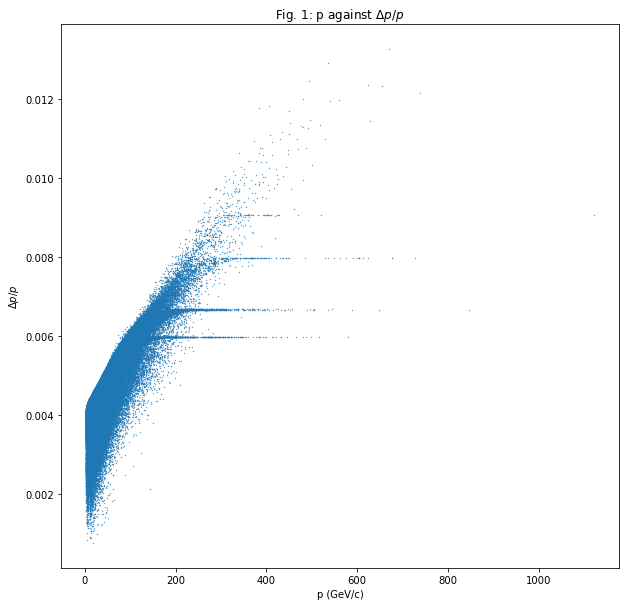

In [69]:
# getting the same domain as the figure, to highlight the bands
x = df.p
y = predicted
# getting the same range as the figure
# y = df.ep[df.ep <= 0.012]
# x = df.p[df.ep <= 0.012]
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, 0.1)
ax.set_xlabel("p (GeV/c)")
ax.set_ylabel(r"$\Delta p/p$")
ax.set_title("Fig. 1: p against $\Delta p/p$ predicted")
plt.show()